# Libraries

In [1]:
from datetime import datetime
current_time = datetime.now()
print("Main Process Start date and time:", current_time)

Main Process Start date and time: 2024-11-10 13:34:01.697936


In [2]:
#!pip install imbalanced-learn

In [56]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, f1_score, recall_score, precision_score
import tensorflow as tf
from tensorflow.keras import layers, models

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from tensorflow.keras.utils import plot_model

import seaborn as sns
from pylab import rcParams
#from matplotlib import pyplot as plt
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

# Load Dataset

## 1. Load the DS

In [4]:
df = pd.read_csv("Kaggle-credit-card-fraud-detection-US_13Jul24/creditcard.csv")  # Imbalanced DS
#df = pd.read_csv("Kaggle-credit-card-fraud-detection_18Sep23/creditcard_2023.csv") # Balanced DS


In [5]:
print(df.head())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

# Exploration

In [6]:
df.shape

(284807, 31)

In [7]:
# Check Null
df.isnull().values.any()

False

C:\Users\flyin\AppData\Local\Temp\ipykernel_11788\4095103176.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['Class'], sort = True)


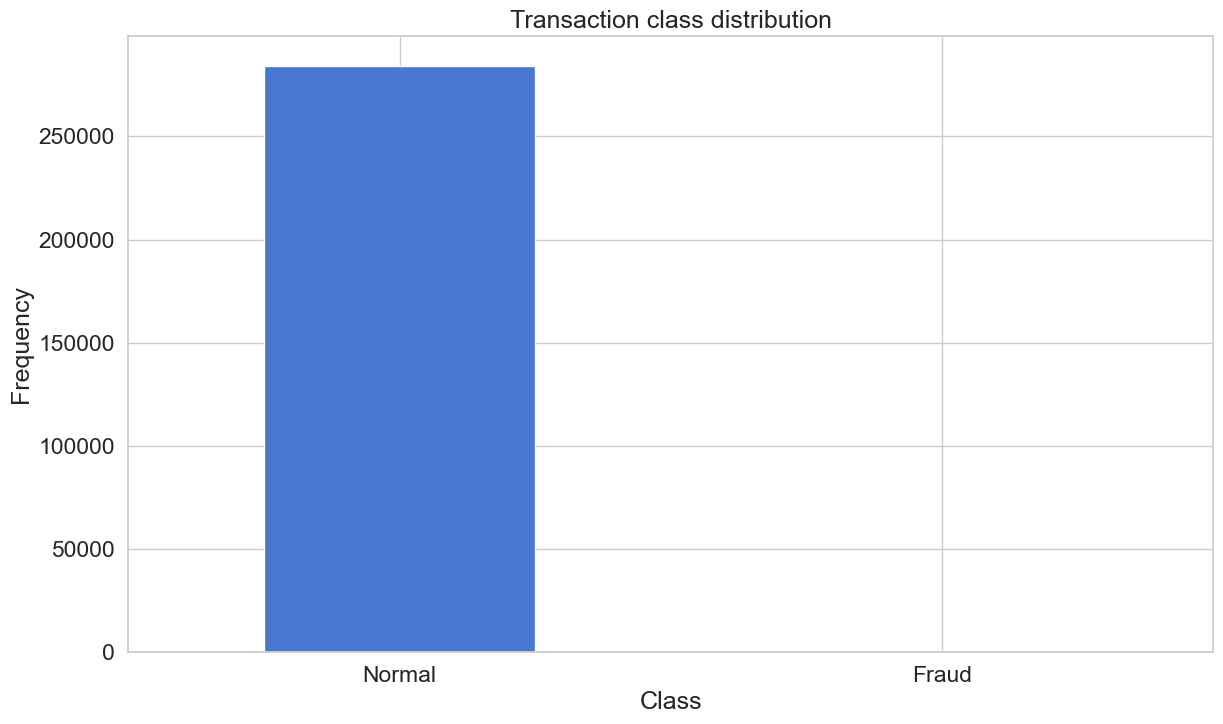

In [8]:
# Visualization
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

We have a highly imbalanced dataset on our hands. Normal transactions overwhelm the fraudulent ones by a large margin. Let's look at the two types of transactions:

In [9]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

In [10]:
print("frauds.shape:", frauds.shape)
print("normal.shape:", normal.shape)

frauds.shape: (492, 31)
normal.shape: (284315, 31)


# Data Preprocessing

### 2. Separate features and labels

In [11]:
X = df.drop(['Class'], axis=1)  # 'Class' is the fraud label
y = df['Class']

In [12]:
print("X.shape:", X.shape)
print("y.shape:", y.shape)

X.shape: (284807, 30)
y.shape: (284807,)


### 3. Split the data into training and testing sets
### (Output: X_train, X_test, y_train, y_test)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [14]:
print("X_train.shape:", X_train.shape)
print("X_test.shape:", X_test.shape)
print("y_train.shape:", y_train.shape)
print("y_test.shape:", y_test.shape)

X_train.shape: (227845, 30)
X_test.shape: (56962, 30)
y_train.shape: (227845,)
y_test.shape: (56962,)


# Handling Imbalanced Data with SMOTE

### 4. Handling Imbalanced Data with SMOTE
### (Output: X_train_sm, y_train_sm )

1. Over-sampling: SMOTE doesn't just duplicate existing minority class instances. Instead, it creates new synthetic samples by interpolating between existing minority class examples.
2. Synthetic Samples: For each instance in the minority class (fraud cases), SMOTE randomly selects one of its nearest neighbors and generates a synthetic point along the line connecting the two instances.

In [15]:
# Instantiate SMOTE
smote = SMOTE(random_state=RANDOM_SEED)

# Apply SMOTE to the training data
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# Checking the distribution of the classes after resampling
print(f"Original training set class distribution:\n{y_train.value_counts()}")
print(f"Resampled training set class distribution:\n{y_train_sm.value_counts()}")

Original training set class distribution:
Class
0    227451
1       394
Name: count, dtype: int64
Resampled training set class distribution:
Class
0    227451
1    227451
Name: count, dtype: int64


In [16]:
print("X_train_sm.shape:", X_train_sm.shape[1])
print("y_train_sm.shape:", y_train_sm.shape)

X_train_sm.shape: 30
y_train_sm.shape: (454902,)


### 5. Standardize the features after applying SMOTE
### (X_train_sm_scaled, X_test_scaled)

Feature scaling is applied using StandardScaler, which standardizes the features by removing the mean and scaling them to unit variance.

In [17]:
# Instantiate the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the resampled training data and transform it
X_train_sm_scaled = scaler.fit_transform(X_train_sm)

# Transform the test data as well (but do NOT fit the scaler again)
X_test_scaled = scaler.transform(X_test)

# Check the scaled feature distributions (optional)
print(f"Mean of scaled training features:\n{np.mean(X_train_sm_scaled, axis=0)}")
print(f"Standard deviation of scaled training features:\n{np.std(X_train_sm_scaled, axis=0)}")

Mean of scaled training features:
[ 1.57946286e-16  5.29819820e-17  1.58945946e-16 -5.99796023e-17
 -9.49677037e-17 -1.27956485e-16  8.09724631e-17  1.00965664e-16
 -3.99864015e-18  7.39748429e-17  4.79836819e-17  5.29819820e-17
  1.96933028e-16 -1.12461754e-18 -1.49949006e-17 -2.87402261e-18
 -1.01965324e-16 -1.04964304e-16  5.79802822e-17 -1.49949006e-17
  6.59775625e-17  9.99660039e-19 -1.67443056e-17  5.49813021e-18
 -1.59945606e-17  1.74628113e-17  1.63694331e-17 -4.99830019e-19
  8.37215282e-18  1.05151740e-16]
Standard deviation of scaled training features:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


# Unsupervised Learning with Autoencoder for Anomaly Detection

### 6. Unsupervised Learning with Autoencoder for Anomaly Detection
### (X_train_scaled2, X_test_scaled2)

Epoch 1/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 966us/step - loss: 0.4767 - val_loss: 0.3550
Epoch 2/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3437 - val_loss: 0.3379
Epoch 3/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3318 - val_loss: 0.3347
Epoch 4/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3346 - val_loss: 0.3322
Epoch 5/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3286 - val_loss: 0.3301
Epoch 6/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3366 - val_loss: 0.3286
Epoch 7/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3314 - val_loss: 0.3277
Epoch 8/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3439 - val_loss: 0.3268
Epoch 9/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 956us/step - loss: 0.3287 - val_loss: 0.3260
Epoch 10/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3223 - val_loss: 0.3253
Epoch 11/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3257 - val_loss: 0.3249
Epoch 12/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/

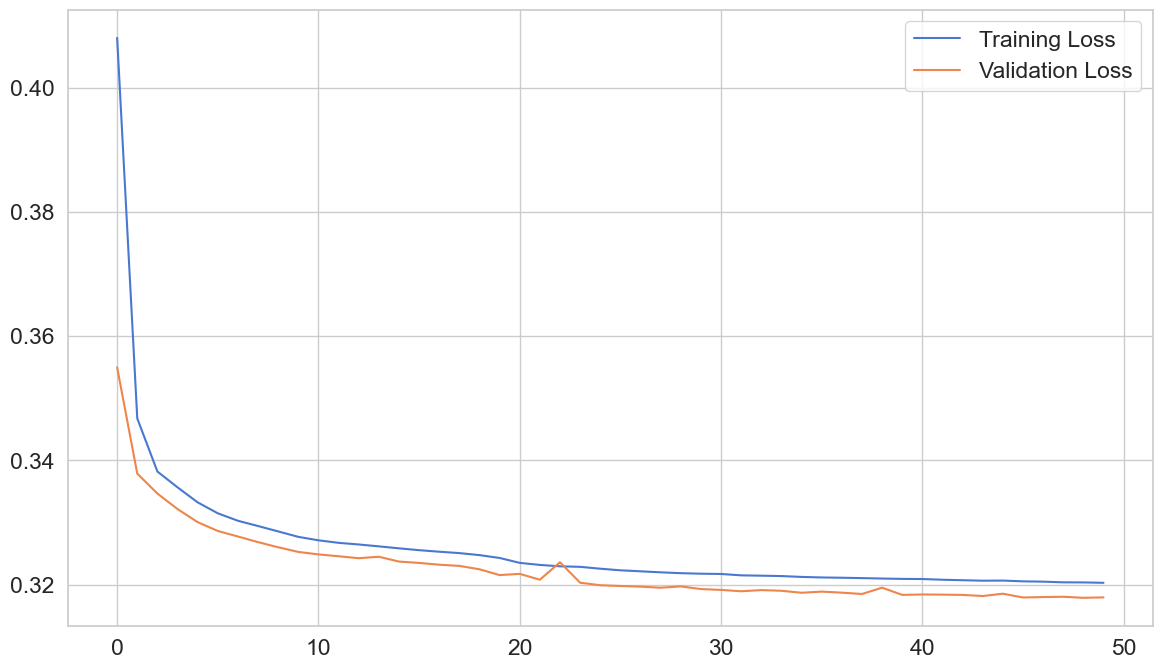

In [18]:
# 6. Unsupervised Learning with Autoencoder

# First, create a subset of the data with only normal transactions (Class 0) for training the autoencoder
X_train_autoencoder = X_train_sm_scaled[y_train_sm == 0]  # Only normal transactions for training the autoencoder

# Define the autoencoder model
autoencoder = models.Sequential([
    layers.Input(shape=(X_train_autoencoder.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),  # Bottleneck layer (smallest representation)
    layers.Dense(16, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(X_train_autoencoder.shape[1], activation='sigmoid')  # Output layer
])

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder with normal data
history = autoencoder.fit(X_train_autoencoder, X_train_autoencoder,
                          epochs=50,
                          batch_size=256,
                          validation_split=0.1,
                          shuffle=True)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


### 7. Generate reconstruction errors
### (reconstructed_data, mse, reconstructed_test_data, test_mse)

In [19]:
# Generate reconstruction errors for the training set
X_train_sm_pred = autoencoder.predict(X_train_sm_scaled)
train_reconstruction_errors = np.mean(np.square(X_train_sm_scaled - X_train_sm_pred), axis=1)

# Generate reconstruction errors for the test set
X_test_pred = autoencoder.predict(X_test_scaled)
test_reconstruction_errors = np.mean(np.square(X_test_scaled - X_test_pred), axis=1)

# Print the reconstruction error distributions (optional)
print(f"Reconstruction errors on the training set: {train_reconstruction_errors[:5]}")
print(f"Reconstruction errors on the test set: {test_reconstruction_errors[:5]}")

14216/14216 ━━━━━━━━━━━━━━━━━━━━ 7s 499us/step
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 448us/step
Reconstruction errors on the training set: [0.2742395  0.19006446 0.54264826 0.18512053 0.43326908]
Reconstruction errors on the test set: [0.14308182 0.50806359 0.57940415 0.10090393 0.19130658]


### 8. Add the reconstruction error as a feature to the original dataset
### (X_train_sm_with_errors_df, X_test_with_errors_df)

In [20]:
# Add the reconstruction error to the training set
X_train_sm_with_errors = np.c_[X_train_sm_scaled, train_reconstruction_errors]

# Add the reconstruction error to the test set
X_test_with_errors = np.c_[X_test_scaled, test_reconstruction_errors]

# Convert back to a DataFrame for clarity (optional)
X_train_sm_with_errors_df = pd.DataFrame(X_train_sm_with_errors)
X_test_with_errors_df = pd.DataFrame(X_test_with_errors)

# Add column names (optional)
feature_names = [f"feature_{i}" for i in range(X_train_sm_scaled.shape[1])]
feature_names.append("reconstruction_error")
X_train_sm_with_errors_df.columns = feature_names
X_test_with_errors_df.columns = feature_names

# Check the new dataset (optional)
print(X_train_sm_with_errors_df.head())

   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0   1.517482   0.804044  -0.730104   0.369177  -0.949778   0.754561   
1   0.739544   0.820274  -0.534474   0.093771  -0.661579   1.103696   
2  -0.990902   0.264538  -0.353182   0.703355  -1.054590   0.190226   
3   0.908815   0.866275  -0.937985   0.467399  -1.268684   0.052501   
4  -0.613423   0.364258  -0.802088   0.606991  -1.834810   0.563824   

   feature_6  feature_7  feature_8  feature_9  ...  feature_21  feature_22  \
0   2.812865   0.246889   0.171154   1.237646  ...   -0.101682    0.257532   
1   2.381830   0.507576   0.070471   0.620903  ...   -0.116574    0.193383   
2   1.585068   0.117567  -1.166115   0.600486  ...   -1.241195    0.083595   
3   0.216055   0.256007  -0.073438   0.093304  ...   -0.187254    0.053516   
4   0.336450   0.596951  -0.100243   0.579843  ...   -0.228313   -0.178058   

   feature_23  feature_24  feature_25  feature_26  feature_27  feature_28  \
0    0.318804    1.382788  

# Unsupervised Learning with KMeans Clustering

### 9. Converted column names to strings to avoid issues with KMeans.
### (X_train_sm_with_errors_df, X_test_with_errors_df)

In [21]:
# Convert column names to strings (if they are not already)
X_train_sm_with_errors_df.columns = X_train_sm_with_errors_df.columns.map(str)
X_test_with_errors_df.columns = X_test_with_errors_df.columns.map(str)

# Verify column names are strings (optional)
print(X_train_sm_with_errors_df.columns)

Index(['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4',
       'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9',
       'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14',
       'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19',
       'feature_20', 'feature_21', 'feature_22', 'feature_23', 'feature_24',
       'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_29',
       'reconstruction_error'],
      dtype='object')


### 10. Generate the cluster labels as features
### (train_cluster_labels, test_cluster_labels)

In [22]:
# Instantiate KMeans with a chosen number of clusters (tunable parameter)
kmeans = KMeans(n_clusters=2, random_state=RANDOM_SEED)

# Fit KMeans on the training set with reconstruction errors
kmeans.fit(X_train_sm_with_errors_df)

# Generate cluster labels for the training and test sets
train_cluster_labels = kmeans.predict(X_train_sm_with_errors_df)
test_cluster_labels = kmeans.predict(X_test_with_errors_df)

# Check the first few cluster labels (optional)
print(f"Cluster labels for training set: {train_cluster_labels[:5]}")
print(f"Cluster labels for test set: {test_cluster_labels[:5]}")


Cluster labels for training set: [0 0 0 0 0]
Cluster labels for test set: [0 0 0 0 0]


### 11 Added these cluster labels as a new feature to both the training and test datasets.
### Output: (X_train_final_df, X_test_final_df)

In [23]:
# Add cluster labels to the training set
X_train_final = np.c_[X_train_sm_with_errors_df, train_cluster_labels]

# Add cluster labels to the test set
X_test_final = np.c_[X_test_with_errors_df, test_cluster_labels]

# Convert back to DataFrames for clarity (optional)
X_train_final_df = pd.DataFrame(X_train_final)
X_test_final_df = pd.DataFrame(X_test_final)

# Add column names for the new cluster feature
X_train_final_df.columns = list(X_train_sm_with_errors_df.columns) + ['cluster_label']
X_test_final_df.columns = list(X_test_with_errors_df.columns) + ['cluster_label']

# Check the final datasets (optional)
print(X_train_final_df.head())
print(X_test_final_df.head())

   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0   1.517482   0.804044  -0.730104   0.369177  -0.949778   0.754561   
1   0.739544   0.820274  -0.534474   0.093771  -0.661579   1.103696   
2  -0.990902   0.264538  -0.353182   0.703355  -1.054590   0.190226   
3   0.908815   0.866275  -0.937985   0.467399  -1.268684   0.052501   
4  -0.613423   0.364258  -0.802088   0.606991  -1.834810   0.563824   

   feature_6  feature_7  feature_8  feature_9  ...  feature_22  feature_23  \
0   2.812865   0.246889   0.171154   1.237646  ...    0.257532    0.318804   
1   2.381830   0.507576   0.070471   0.620903  ...    0.193383    0.056558   
2   1.585068   0.117567  -1.166115   0.600486  ...    0.083595   -0.397964   
3   0.216055   0.256007  -0.073438   0.093304  ...    0.053516    0.222903   
4   0.336450   0.596951  -0.100243   0.579843  ...   -0.178058    0.015894   

   feature_24  feature_25  feature_26  feature_27  feature_28  feature_29  \
0    1.382788   -0.572630  

# Supervised Learning using Deep learning model

### 12. Supervised Learning using Deep learning model

In [37]:
print("X_train_final_df.shape:", X_train_final_df.shape)
print("input_shape:", (X_train_final_df.shape[1],))

X_train_final_df.shape: (454902, 32)
input_shape: (32,)


In [24]:
# Define the deep learning model
model = models.Sequential([
    layers.InputLayer(input_shape=(X_train_final_df.shape[1],)),  # Input size is number of features
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


C:\Installed\Python_3.12\Lib\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,225 (16.50 KB)

 Trainable params: 4,225 (16.50 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Train the model
history = model.fit(X_train_final_df, 
                    y_train_sm, 
                    epochs=50, 
                    batch_size=256,
                    validation_split=0.2)



Epoch 1/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9637 - loss: 0.0996 - val_accuracy: 0.9937 - val_loss: 0.0176
Epoch 2/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 1s 838us/step - accuracy: 0.9960 - loss: 0.0133 - val_accuracy: 0.9937 - val_loss: 0.0172
Epoch 3/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 1s 925us/step - accuracy: 0.9982 - loss: 0.0069 - val_accuracy: 0.9984 - val_loss: 0.0062
Epoch 4/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 3s 916us/step - accuracy: 0.9989 - loss: 0.0044 - val_accuracy: 0.9962 - val_loss: 0.0123
Epoch 5/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9990 - loss: 0.0035 - val_accuracy: 0.9998 - val_loss: 0.0026
Epoch 6/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 2s 727us/step - accuracy: 0.9993 - loss: 0.0026 - val_accuracy: 0.9995 - val_loss: 0.0020
Epoch 7/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 2s 993us/step - accuracy: 0.9994 - loss: 0.0021 - val_accuracy: 0.9967 - val_loss: 0.0096
Epoch 8/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 1s 872us/step - accuracy: 0.9993 - los

# Performance graph2

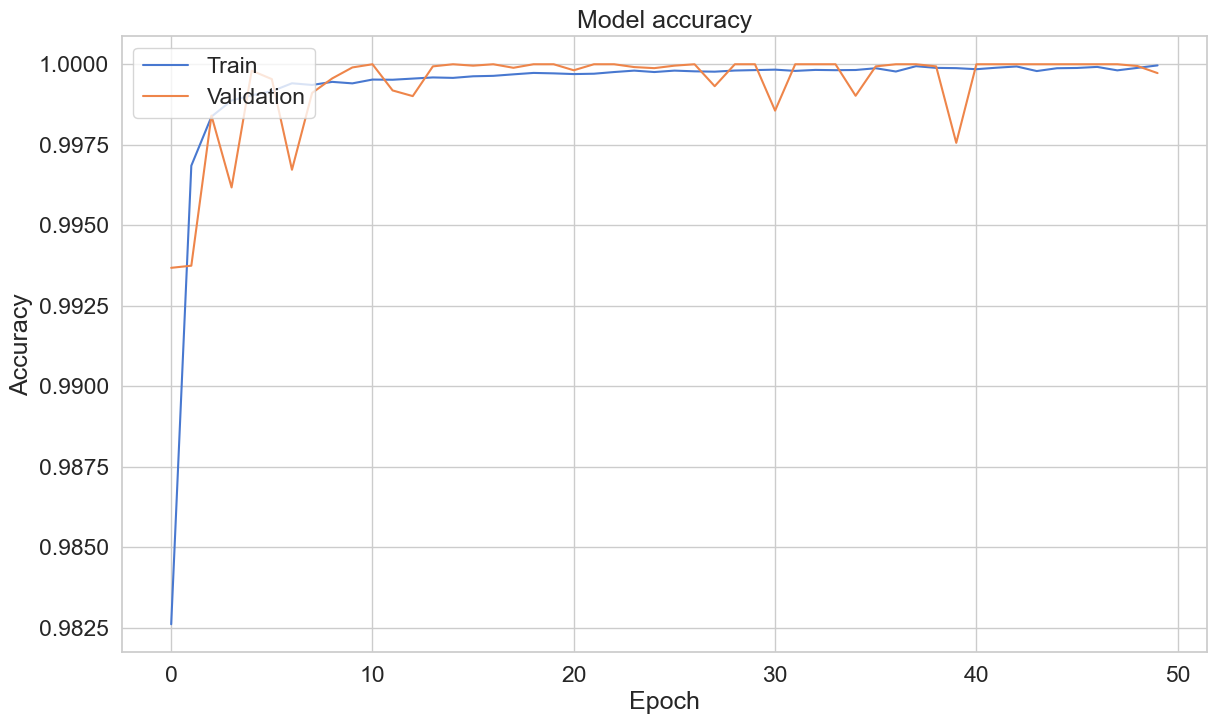

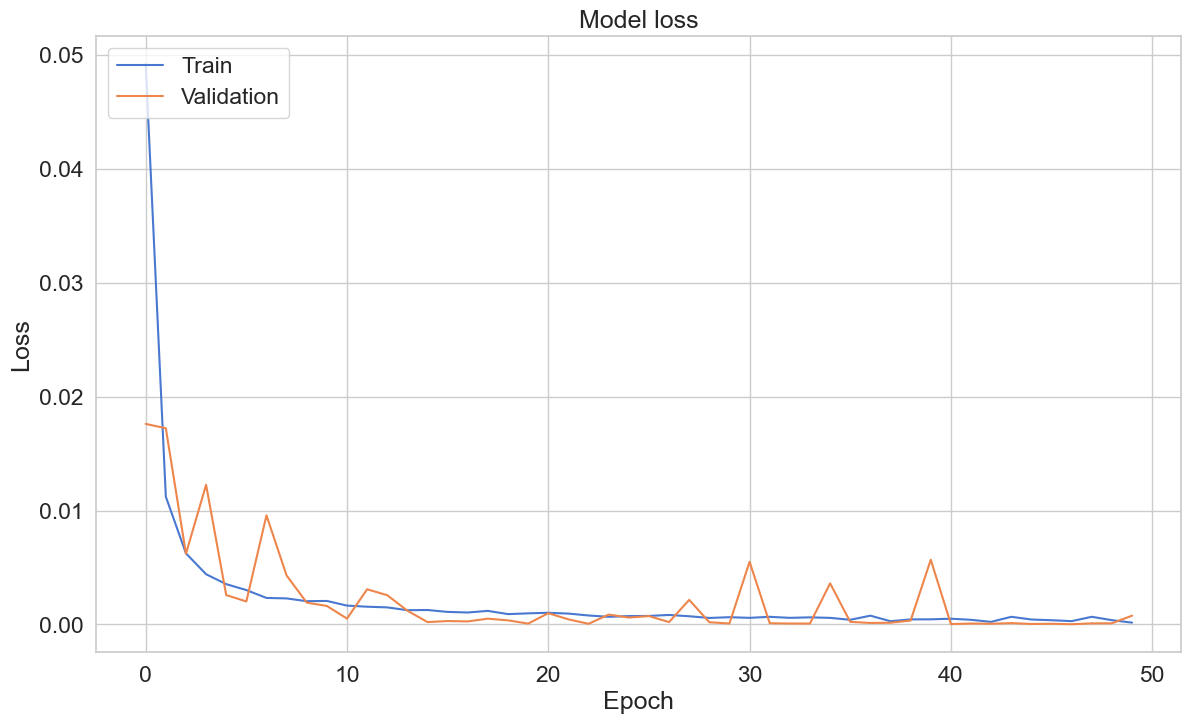

In [26]:
import matplotlib.pyplot as plt

def plot_performance(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Call the function with the training history
plot_performance(history)


### 13. Make predictions

In [27]:
# 13. Make predictions

# Make predictions on the test set
y_test_pred = model.predict(X_test_final_df)

# Convert predicted probabilities to binary labels (0 or 1)
y_test_pred_labels = (y_test_pred > 0.5).astype(int)

# Check predictions (optional)
print(f"First 5 predictions: {y_test_pred_labels[:5]}")


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 447us/step
First 5 predictions: [[0]
 [0]
 [0]
 [0]
 [0]]


### 14. Model evaluation

In [71]:
# Classification report
print("Classification Report:")
print(classification_report(y_test, y_test_pred_labels))

f1 = f1_score(y_test, y_test_pred_labels, average='macro')
recall = recall_score(y_test, y_test_pred_labels, average='macro')
precision = precision_score(y_test, y_test_pred_labels, average='macro')
roc_auc = roc_auc_score(y_test, y_test_pred)

# Print the results
print("F1 Score:", f1)
print("Recall Score:", recall)
print("Precision Score:", precision)
print("ROC-AUC Score:", roc_auc)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.81      0.79      0.80        98

    accuracy                           1.00     56962
   macro avg       0.91      0.89      0.90     56962
weighted avg       1.00      1.00      1.00     56962

F1 Score: 0.8987922733595131
Recall Score: 0.8926988704879814
Precision Score: 0.90507851653859
ROC-AUC Score: 0.9613882711919882


### 15. Plotting the ROC Curve (Optional)

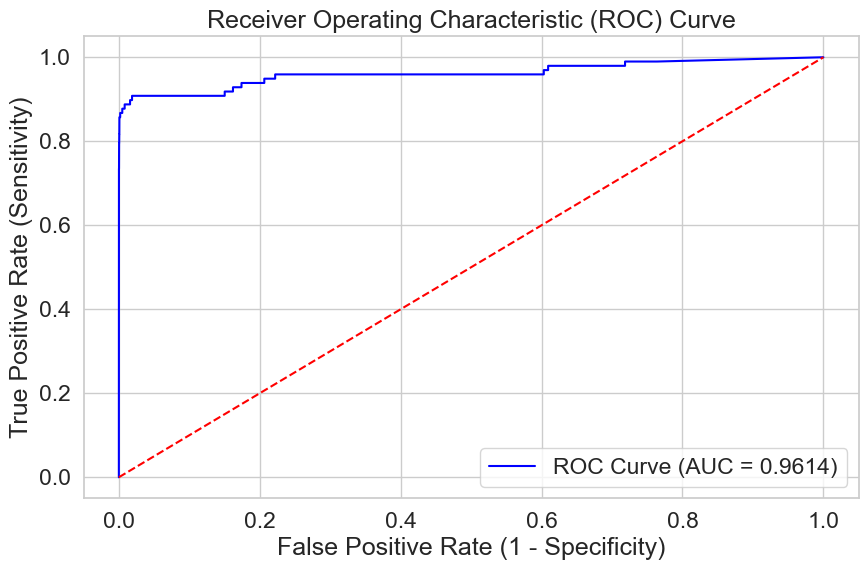

In [46]:
# Generate ROC curve values
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.show()

### 16. Confusion Matrix

Confusion Matrix:
[[56846    18]
 [   21    77]]


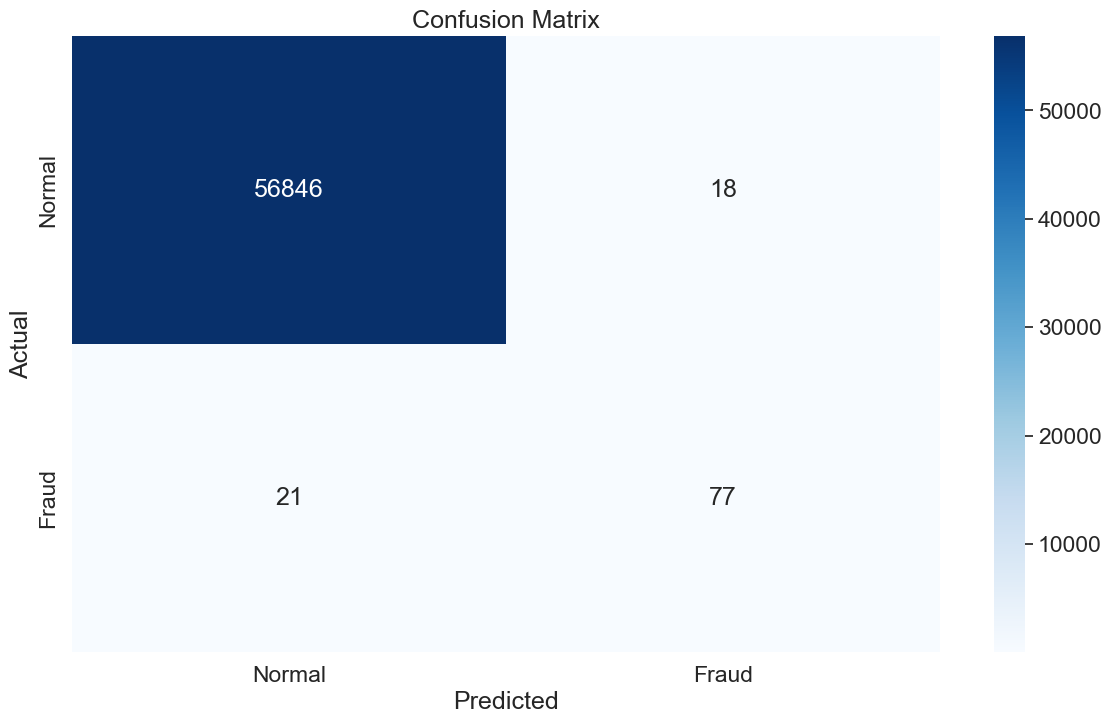

In [49]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred_labels)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# You can visualize the confusion matrix using seaborn for clarity
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS, yticklabels=LABELS)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [50]:
from datetime import datetime
current_time = datetime.now()
print("Main Process End date and time:", current_time)

Main Process End date and time: 2024-11-10 14:10:12.677071


### 17-Save the Model

In [52]:
#SAVE THE GENERATED MODEL ON DRIVE

import pickle

model.save('SaveFile/final_model.h5')

#with open('/content/gdrive/My Drive/CPS/model.pkl', 'wb') as file:
with open('SaveFile/model.pkl', 'wb') as file:
  pickle.dump(model, file)